<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/Semantic_segmentation_dermoscopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic segmentation

## imports

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from matplotlib import rcParams
from skimage.io import imread
from skimage.transform import resize
from time import time
from torch.utils.data import DataLoader
from torchvision import models
from typing import Callable, List, Dict, Tuple

In [110]:
rcParams['figure.figsize'] = (15,4)

## Download and unzip dataset

In [3]:
%%capture
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

In [4]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [5]:
images = []
lesions = []

for root, dirs, files in os.walk(os.path.join('PH2Dataset', 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

## Set config

In [107]:
class CFG:
  batch_size = 25
  seed = 42
  device = lambda: torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Freeze seeds

In [31]:
def seed_everything(seed: int=CFG.seed) -> None:
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

In [54]:
def seed_wrapper(func: Callable) -> Callable:
    """
    A wrapper function for repeatability and reproducibility.

    Args:
        func (Callable): The function to be wrapped.

    Returns:
        Callable: The wrapped function.
    """
    def wrapped_function(*args, **kwargs):
        seed_everything()
        result = func(*args, **kwargs)
        return result
    return wrapped_function

In [ ]:
seed_everything()

## Dataset

### Resize and transform

In [32]:
size = (256, 256)
X = np.array([resize(x, size, mode='constant', anti_aliasing=True,) for x in images], np.float32)
Y = np.array([resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions], np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


### Preview images

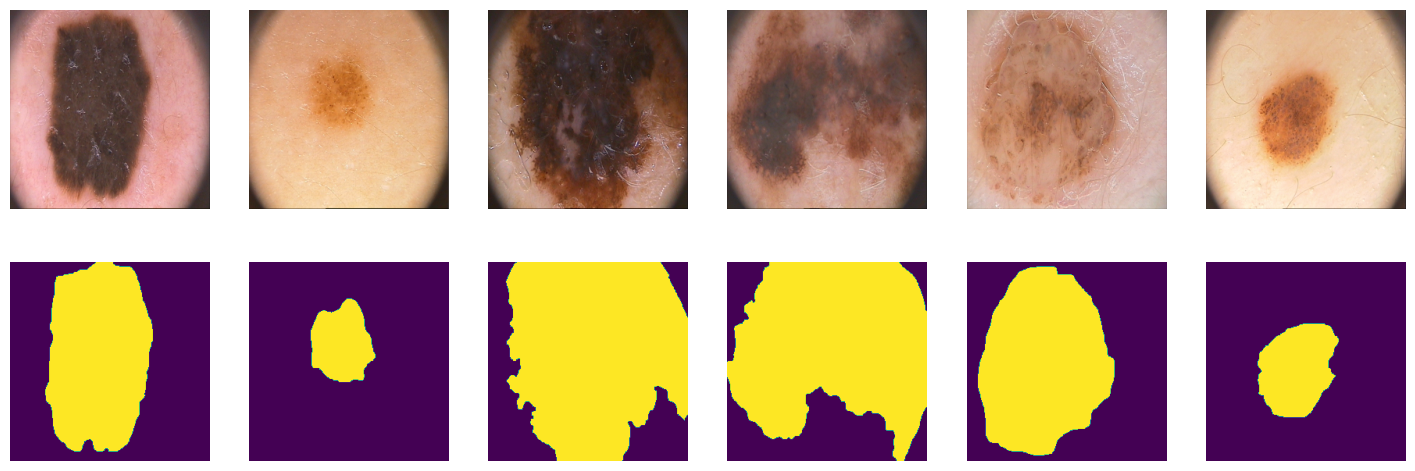

In [7]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

Split indexes

In [85]:
@seed_wrapper
def tvt_split_custom(X):
  idx = np.random.choice(len(X), len(X), False)
  return np.split(idx, [100, 150])

In [86]:
train, val, test = tvt_split_custom(X)

### Create dataloaders

In [87]:
def match_idxs(idx: np.ndarray, xs: np.ndarray = X, ys: np.ndarray = Y) -> list:
    """
    Match indices and create a list of tuples.

    Parameters:
    - idx: np.ndarray
        An array of indices.
    - xs: np.ndarray, optional
        The input array for x (default value X).
    - ys: np.ndarray, optional
        The input array for y (default value Y).

    Returns:
    - list
        A list of tuples created by matching indices.
    """
    x = np.moveaxis(xs[idx], source=3, destination=1)
    y = ys[idx, np.newaxis]
    new_array = list(zip(x, y))
    return new_array

In [89]:
data_train = DataLoader(match_idxs(train), batch_size=CFG.batch_size, shuffle=True)
data_val = DataLoader(match_idxs(val), batch_size=CFG.batch_size, shuffle=True)
data_test = DataLoader(match_idxs(test), batch_size=CFG.batch_size, shuffle=False)


## SegNet

-----------------------------------------------------------------------------------------

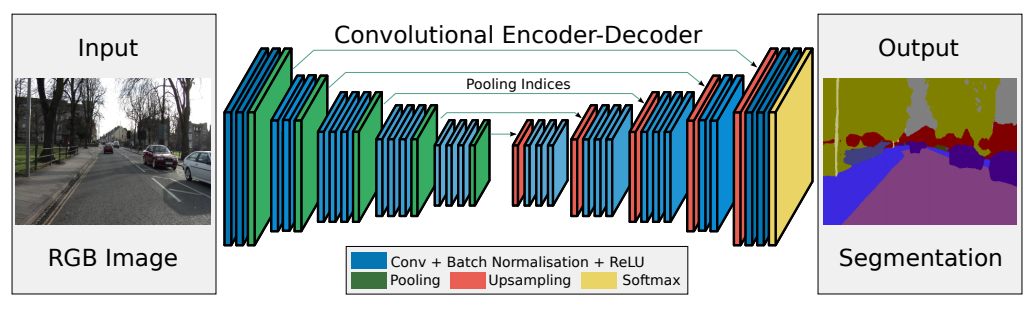

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)